# **Task P8**
## Analyzing Twitter Data using NLP

##### This task focuses on analyzing user replies to Covid-19 news published on the social media platform X (formerly known as Twitter) using some basic natural language processing (NLP) techniques. 

##### The task uses the `replies.csv` dataset, which contains the information about user replies to the Covid-19 news posted on Twitter. The columns capture the content related to the individual replies such as `text` (the actual text content of the reply), `id` (a unique ID for the reply itself), `conversation_id` (linking the reply to a specific conversation thread), `in_reply_to_user_id` (identifying the target user of the reply), and `possibly_sensitive` (indicating if the content may be sensitive). Additional informaiton include `author_id` (the unique ID of the reply's author), `author_followers` (the count of the author's followers),`author_tweets` (total tweets made by the author), and `author_location` (the geographical location of the author). Moreover, engagement metrics are tracked through columns like `retweets`, `replies`, `likes`, and `quote_count`. Time and location metadata are captured by `created_at` and `geo`, respectively, with `account` specifying the account name of the news publishers (e.g., BBC).

<img src="pic.png" alt="SIT112 News Tweets!" width="1800" height="200">

### A. Instructions

1. `To complete this task, you must first study the solution notebook; then try to do it yourself. You can copy the solutions into ChatGPT and ask for clarification or more examples.`
2. Complete and submit the TaskCompletionReport form in PDF format using Ontrack. You can do this by the end of Week 12, but feedback will only be provided for submissions received by 11 AM of the due date.
3. Do **not** include the solution (yours or the one provided to you) in your submission.
4. The workshops are the primary venue for you to seek help if you need any clarification/assitance. The tutors are there to help you complete and submit the tasks. Please avoid emailing your code or screenshots to the tutors outside workshop hours. 
5. Consider using online resources such as ChatGPT to strenghten your undertanding of the task. 

Good luck :)

In [1]:
import importlib
import subprocess

# The following lines should install all libraries you need - you can install the libraries manually if the script did not work 
required_modules = ['pandas', 'seaborn', 'matplotlib', 'numpy', 'datetime', 'sklearn', 'nltk', 'textblob', 'textblob', 'collections', 'numpy', 'warnings']
for module in required_modules:
    try:
        importlib.import_module(module)
    except ImportError:
        print(f"{module} module not found. Installing...")
        subprocess.check_call(['pip', 'install', module])

print("All required modules are installed.")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import datetime as dt
from collections import Counter
import re
import warnings
import nltk
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
# Set the maximum number of columns and rows displayed
pd.set_option('display.max_columns', None)  # None means no limit
pd.set_option('display.max_rows', None)  # None means no limit
# You can also adjust the width of each column and the maximum column width
pd.set_option('display.max_colwidth', None)  # None means no truncation on column width

All required modules are installed.


### B. Write Python code that performs (answers) the following operations (questions) 

##### 1. Read the data from the .csv file into a DataFrame and display the first five rows.

In [2]:
# write your code here
df = pd.read_csv('replies.csv')
df.head(5)



,author_id,author_followers,author_tweets,author_location,id,conversation_id,source,in_reply_to_user_id,possibly_sensitive,text,created_at,geo,retweets,replies,likes,quote_count,account
0,2,1,3827,NaN,1.480000e+18,1.480000e+18,NaN,2.604917e+07,False,@RobinLaRoca @guardian I don't want a payment.\nI want the unvaxxed to pay every last red cent for public hospital treatment rendered to them,2022-01-01T03:31:03Z,NaN,0,2,0,0,guardian
1,3,939,49244,Sheffield,1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,@guardian I'm fine with that as long as they backdate the payments for everyone.,2022-01-01T00:42:39Z,{'place_id': '07e9c7d1954fff64'},0,1,0,0,guardian
2,4,318,4519,"Santiago, Chile",1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,"@guardian Yes, for big pharma",2022-01-01T00:37:59Z,NaN,1,0,1,0,guardian
3,5,2812,320641,Earth,1.480000e+18,1.480000e+18,NaN,1.367531e+06,False,@FoxNews a vaccine most Missourians won’t take,2022-01-01T07:39:51Z,NaN,0,0,5,0,FoxNews
4,6,350,1581,"Conway, AR",1.480000e+18,1.480000e+18,NaN,1.190000e+18,False,"@nikki6ixx1 @FoxNews I currently have Covid, im non vaccinated and feeling perfectly fine. Please explain to me how am I going to die because of this virus??",2022-01-01T13:30:39Z,NaN,0,2,0,0,FoxNews


##### 2. Clean the reply texts as listed below. You can use ChatGPT to generate regular expressions for these cleaning operations. 

- Remove @ Mentions: Strip out any @ mentions in the reply texts, which typically refer to other users and are not relevant for general analysis.
- Remove Hashtags: Eliminate the '#' symbol but keep the subsequent text, which might be relevant for understanding the topic of the reply.
- Remove Retweet Indicators: Remove any 'RT' symbols used to indicate retweets, as they do not contribute to text content.
- Remove URLs: Strip out any web links (URLs), which are common in reply texts but irrelevant to text analysis.
- Remove Punctuation: Eliminate all punctuation marks to reduce variability in the reply texts.
- Convert to Lowercase: Standardize all reply texts to lowercase to ensure uniformity in the analysis.

In [3]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove @ mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'\bRT\b', '', text)  # Remove retweet indicators
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    return text

# Apply the cleaning function to the 'reply' column
df['text'] = df['text'].apply(clean_text)


# Display the first few rows of the cleaned data
df.head(5)


,author_id,author_followers,author_tweets,author_location,id,conversation_id,source,in_reply_to_user_id,possibly_sensitive,text,created_at,geo,retweets,replies,likes,quote_count,account
0,2,1,3827,NaN,1.480000e+18,1.480000e+18,NaN,2.604917e+07,False,i dont want a payment\ni want the unvaxxed to pay every last red cent for public hospital treatment rendered to them,2022-01-01T03:31:03Z,NaN,0,2,0,0,guardian
1,3,939,49244,Sheffield,1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,im fine with that as long as they backdate the payments for everyone,2022-01-01T00:42:39Z,{'place_id': '07e9c7d1954fff64'},0,1,0,0,guardian
2,4,318,4519,"Santiago, Chile",1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,yes for big pharma,2022-01-01T00:37:59Z,NaN,1,0,1,0,guardian
3,5,2812,320641,Earth,1.480000e+18,1.480000e+18,NaN,1.367531e+06,False,a vaccine most missourians wont take,2022-01-01T07:39:51Z,NaN,0,0,5,0,FoxNews
4,6,350,1581,"Conway, AR",1.480000e+18,1.480000e+18,NaN,1.190000e+18,False,i currently have covid im non vaccinated and feeling perfectly fine please explain to me how am i going to die because of this virus,2022-01-01T13:30:39Z,NaN,0,2,0,0,FoxNews


##### 3. Remove from the reply texts the stopwords and the custom list of words that are unwanted:

- Utilize a list of predefined stopwords from NLTK tailored for the English language (from nltk.corpus import stopwords).
- Define a custom list of words to be excluded that are specifically irrelevant or overused in the reply texts.
- Remove stopwords and custom words: filter out these words from the (reply) text to focus on more meaningful words for analysis.

In [4]:
def remove_words(text):
    # Define a list of words specific to the context that we want to exclude from analysis
    excluded_words = ['vaccine', 'pandemic', 'coronavirus', 'lockdown', 'mask', 'quarantine', 'positive', 'negative', 'case', 
                      'outbreak', 'health', 'government', 'social', 'distancing', 'safe', 'spread', 'symptoms', 'test', 
                      'tested', 'virus', 'work', 'home', 'life', 'time', 'people', 'day']
    # Get the list of all English stopwords
    stop_words = stopwords.words('english')
    # Combine both lists and ensure all words are considered in lowercase
    combined_words = set(stop_words + excluded_words)
    # Reconstruct the text by excluding stopwords and additional excluded words
    text_new = ' '.join(word for word in text.split() if word.lower() not in combined_words)
    return text_new

# Apply the cleaning functions to the 'reply' column
df['text'] = df['text'].apply(remove_words)

df.head(5)


,author_id,author_followers,author_tweets,author_location,id,conversation_id,source,in_reply_to_user_id,possibly_sensitive,text,created_at,geo,retweets,replies,likes,quote_count,account
0,2,1,3827,NaN,1.480000e+18,1.480000e+18,NaN,2.604917e+07,False,dont want payment want unvaxxed pay every last red cent public hospital treatment rendered,2022-01-01T03:31:03Z,NaN,0,2,0,0,guardian
1,3,939,49244,Sheffield,1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,im fine long backdate payments everyone,2022-01-01T00:42:39Z,{'place_id': '07e9c7d1954fff64'},0,1,0,0,guardian
2,4,318,4519,"Santiago, Chile",1.480000e+18,1.480000e+18,NaN,8.781841e+07,False,yes big pharma,2022-01-01T00:37:59Z,NaN,1,0,1,0,guardian
3,5,2812,320641,Earth,1.480000e+18,1.480000e+18,NaN,1.367531e+06,False,missourians wont take,2022-01-01T07:39:51Z,NaN,0,0,5,0,FoxNews
4,6,350,1581,"Conway, AR",1.480000e+18,1.480000e+18,NaN,1.190000e+18,False,currently covid im non vaccinated feeling perfectly fine please explain going die,2022-01-01T13:30:39Z,NaN,0,2,0,0,FoxNews


##### 4. What are the 5 most frequent words in the replies per account (news publisher, e.g., BBC)?

In [7]:
def extract_words(text):
    return re.findall(r'\b\w+\b', str(text).lower())  # Convert to string in case of NaN values

# Apply the extract_words function to each text entry in the 'text' column of the dataframe 'df'
df['words'] = df['text'].apply(extract_words)

# Define a function to combine all words into a single list for each account
def combine_words(words_list):
    combined = []
    for words in words_list:
        combined.extend(words)
    return combined

# Combine words for each account
grouped_words = df.groupby('account')['words'].apply(combine_words)

# Define a function to determine the top 5 most common words in a list of words
def get_top_words(words):
    word_counts = Counter(words)
    return word_counts.most_common(5)

# Apply the get_top_words function to each group of words aggregated by account
top_words_per_account = grouped_words.apply(get_top_words)

# Display the top words per account results
print(top_words_per_account)



account
9NewsAUS                       [(dont, 45), (get, 38), (like, 34), (covid, 29), (still, 23)]
BBCWorld                  [(covid, 108), (dont, 95), (get, 93), (vaccinated, 85), (one, 61)]
CBC                                [(go, 3), (lies, 3), (every, 2), (news, 2), (trucker, 2)]
CNN                  [(covid, 327), (get, 305), (dont, 294), (vaccinated, 212), (like, 173)]
FoxNews              [(covid, 478), (get, 478), (dont, 437), (like, 315), (vaccinated, 286)]
MSNBC                             [(dont, 35), (get, 32), (amp, 31), (one, 31), (covid, 31)]
SkyNews             [(covid, 107), (dont, 103), (vaccinated, 78), (get, 77), (vaccines, 53)]
guardian                        [(dont, 31), (like, 25), (need, 24), (covid, 24), (get, 22)]
timesofindia    [(modi, 14), (ao2022, 12), (novakdjokovic, 12), (pm, 11), (vaccination, 10)]
Name: words, dtype: object


##### 5. Classify the sentiment of each reply as positive, negative, or neutral based on the `text` column. Then visualize the ratio of the replies with positive, negative, or neutral sentiments per news publisher (account). 


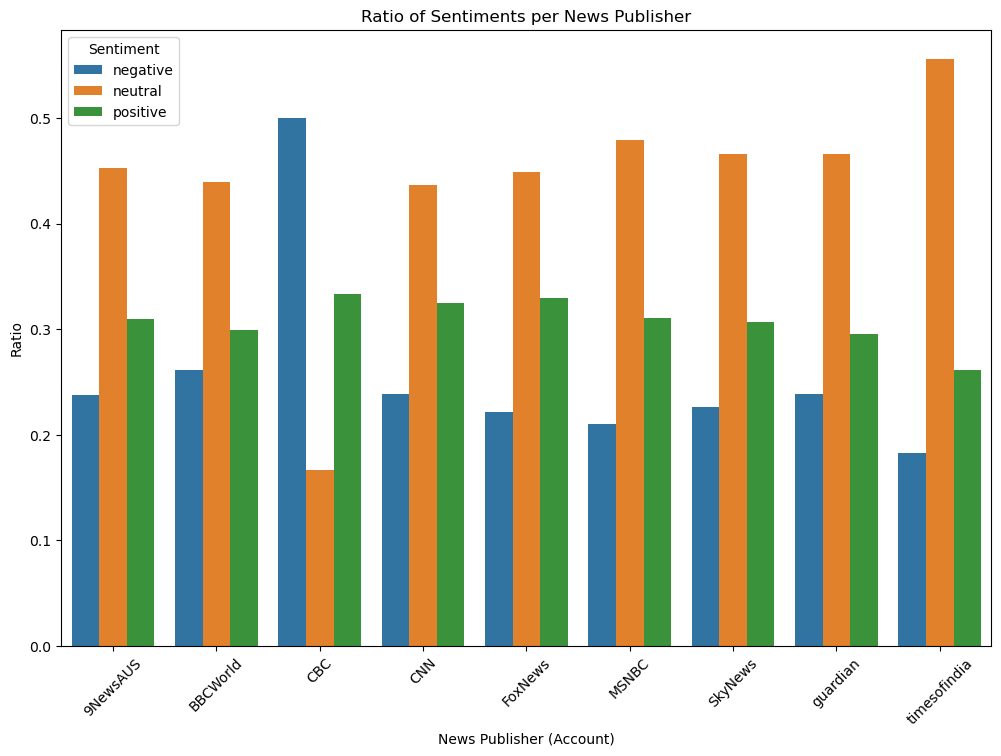

In [8]:
# Define a function to classify sentiment
def classify_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the classify_sentiment function to each text entry in the 'text' column
df['sentiment'] = df['text'].apply(classify_sentiment)

# Group by account and sentiment, then count the occurrences
sentiment_counts = df.groupby(['account', 'sentiment']).size().unstack().fillna(0)

# Calculate the ratio of each sentiment
sentiment_ratios = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Reset index for plotting
sentiment_ratios.reset_index(inplace=True)

# Plot the sentiment ratios
plt.figure(figsize=(12, 8))
sns.barplot(x='account', y='value', hue='sentiment', data=pd.melt(sentiment_ratios, id_vars='account'))
plt.title('Ratio of Sentiments per News Publisher')
plt.ylabel('Ratio')
plt.xlabel('News Publisher (Account)')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()



### C. Learn more
* https://www.sciencedirect.com/science/article/pii/S2468696423000125
* https://youtu.be/toM78JGJ_4s?si=8ESJ-yOV_H1iX74r
* https://youtu.be/QpzMWQvxXWk?si=CPvNgnZo3jsW4HL5
* https://youtu.be/o7OqhzMcDfs?si=9iFeYZq4TlVCMMRb